In [1]:
from Bio import SeqIO
import matplotlib.pyplot as plt
import numpy as np
import re
from collections import Counter
import pandas as pd
import io
import itertools

In [2]:
human_chy = '../data/Homo_sapiens.GRCh38.dna_sm.chromosome.Y.fa'
motifs_input = '../data/human_motifs.fa'

In [85]:
def seq_ACGT(seuil_proba, motif,file):
    seq_ACGT = []
    for i in range(0,len(motif), 4):
        seq = motif[i:i+4]
        tmp = []
        if float(seq[0]) >= seuil_proba:
            tmp.append('A')
        if float(seq[1]) >= seuil_proba:
            tmp.append('C')
        if float(seq[2]) >= seuil_proba:
            tmp.append('G')
        if float(seq[3]) >= seuil_proba:
            tmp.append('T')
        seq_ACGT.append(tmp)
    file.write('\n'.join(map(''.join,list(itertools.product(*seq_ACGT)))))
    file.write('\n')

In [86]:
with open(motifs_input) as fasta_file:  # Will close handle cleanly
    identifiers = []
    seq_ADN = []
    lengths = []
    for seq_record in SeqIO.parse(fasta_file, 'fasta'):  # (generator)
        identifiers.append(seq_record.id)
        seq_ADN.append(seq_record.seq)
        lengths.append(len(seq_record.seq))
file = open('motifs_ATFG.txt',"w")

motifs = []
for i in range(0,len(seq_ADN)):
    seq = re.findall('\d.\d{6}',str(seq_ADN[i]))
    seq_ACGT(0.25,seq, file)
file.close()

In [18]:
file = open('motifs_ATFG.txt',"w")
file.close()

['0.008511', '0.004255', '0.987234', '0.000000']

In [115]:
data = pd.read_csv('motifs_ATFG.txt', header = None)
samples_nb = 200
motifs_df = data.sample(n = samples_nb)
motifs_df

,0
42241552,AATGGTACTGGAAAATTTGGTTTAAA
18749069,GCGAAGCGCACTGAAGAATGGCGGGCCC
21667805,GCGTAGGGCAAGGATGCATAGAGGGCCC
21697678,GCGTAGGGCACCGAAGAATAGACGCTGT
32876182,TCGTGACTCAGCGTAGAAGAGAGGCTGT
...,...
37046901,AAAAATAACGAAACAATCCCACATCACACC
20914640,GCGTAACTCACTGTAGAATGGAGACTGC
29332339,TCGAAGCGCACCGAAGCGTGGAGGCTCT
3118777,CCCAAGGGCACCGAAGAGGAGACAGTCT


In [116]:
motifs_df.iloc[1,0][0]

'G'

Longueur minimum d"un motif :  16
Longueur maximal d"un motif :  30


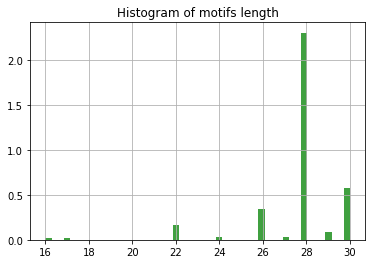

In [117]:
# the histogram of motifs length
x = [len(motifs_df.iat[i,0]) for i in range(0,len(motifs_df.index))]
print('Longueur minimum d"un motif : ', min(x))
print('Longueur maximal d"un motif : ', max(x))
n, bins, patches = plt.hist(x, 50, density=True, facecolor='g', alpha=0.75)
plt.title('Histogram of motifs length')
plt.grid(True)
plt.show()

In [118]:
nucl_counts = dict()
for i in range(0,len(motifs_df.index)):
  for i in motifs_df.iat[i,0]:
    nucl_counts[i] = nucl_counts.get(i, 0) + 1
nucl_counts

{'A': 1490, 'T': 998, 'G': 1611, 'C': 1445}

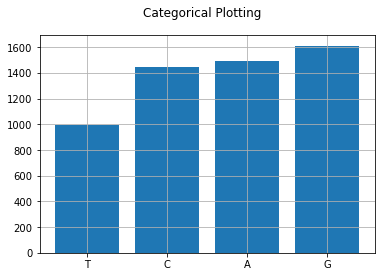

In [119]:
nucl_counts_sorted = { k : v for k, v in sorted(nucl_counts.items(), key=lambda item: item[1])}

names = list(nucl_counts_sorted.keys())
values = list(nucl_counts_sorted.values())

plt.bar(names, values)
plt.suptitle('Categorical Plotting')
plt.grid()
plt.show()

In [120]:
#dire si une séquence est ou non motif

def est_motif(motifs_df,seq,seuil):
    n,m = len(motifs_df.index),len(seq)
    for i in range(n):
        cur_dist = 0
        if len(motifs_df.iat[i,0]) == m:
            for j in range(m):
                if motifs_df.iloc[i,0][0][j] == 'A' and seq[j] != 'A':
                    cur_dist +=1
                    #print("incrémente 1")
                elif motifs_df.iloc[i,0][0][j] == 'T' and seq[j] != 'T':
                    cur_dist +=1
                    #print("incrémente 2")
                elif motifs_df.iloc[i,0][0][j] == 'G' and seq[j] != 'G':
                    cur_dist +=1
                    #print("incrémente 3")
                elif motifs_df.iloc[i,0][0][j] == 'C' and seq[j] != 'C':
                    cur_dist +=1
                    #print("incrémente 4")
            print('cur dist',cur_dist)
            print('cur %',int(seuil*m)+1)
            if cur_dist <= int(seuil*m)+1:
                return True
    return False

On prend la séquence d'adn du chromosome Y et on le met en majuscule

In [121]:
with open(human_chy) as fasta_file:  # Will close handle cleanly
    identifiers = []
    seq_ADN = []
    lengths = []
    for seq_record in SeqIO.parse(fasta_file, 'fasta'):  # (generator)
        identifiers.append(seq_record.id)
        seq_ADN.append(seq_record.seq)
        lengths.append(len(seq_record.seq))
seq_ADN = str(seq_ADN[0])
seq_ADN = seq_ADN.upper()

In [122]:
i = 0
while seq_ADN[i] == 'N': 
    i+=1
seq_ADN = seq_ADN[i:]

In [123]:
seq_ADN[0:4]

'GGCC'

A présent, on a notre séquence d'adn dans une string et on a enlevé tous les N du début

In [124]:
def rolling_stone(liste_motifs,seq_ADN,seuil):
    non_motif_list = []
    batchsize = 25
    for i in range(0,len(seq_ADN), batchsize):
        batch = seq_ADN[i: i+batchsize]
        for j in range(0,batchsize-5):
            if est_motif(liste_motifs,batch[0:j+5],seuil) == False and batch[0:j+5] not in non_motif_list: #On ajoute ce non-motif à la liste
                non_motif_list.append(batch[0:j+5])
                break
            if len(non_motif_list) >= 2000:
                break
        if len(non_motif_list) >= 2000:
                max_i = i
                break
    print('max i : ',max_i)      
    return non_motif_list



In [127]:
non_motif_list = rolling_stone(motifs_df, seq_ADN, 0.3)
len(non_motif_list)

max i :  49975


2000

Longueur minimum d"un motif :  5
Longueur maximal d"un motif :  9


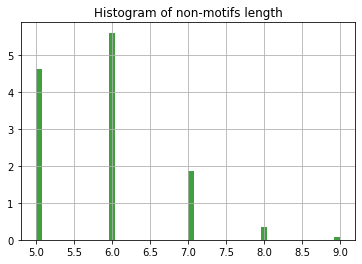

In [126]:
# the histogram of motifs length
x = [len(non_motif_list[i]) for i in range(0,len(non_motif_list))]
print('Longueur minimum d"un motif : ', min(x))
print('Longueur maximal d"un motif : ', max(x))
n, bins, patches = plt.hist(x, 50, density=True, facecolor='g', alpha=0.75)
plt.title('Histogram of non-motifs length')
plt.grid(True)
plt.show()